In [1]:
import sys
import arviz as az
import pandas as pd 
import numpy as np
import pickle
import seaborn as sns
sys.path.append('../Advanced-statistics/modules/')
from analysis_plot import *
from utils import *
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image 


%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256)))

bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

#  Analytical solution of the SCIR model at low fraction of infected individuals

The SCIR model includes the usual states of an SIR model plus a new class C for individuals
sent to confinement that are susceptible but not infected.

## Fit ending before peak data for the daily number of active cases
fit from 2020-02-24 to 2020-03-29 with confinement measure aplied on 2020-03-09

# Dataset Italy
The data is taken from Protezione Civile site, starting from 2020.02.24.

In [16]:
df = pd.read_csv('../Advanced-statistics/Data/dataset_ita.csv')

df

,Day,Confirmed,Recovered,Death,Active_cases,Active_cases_smooth,Recovered_Death,Recovered_Death_smooth
0,2020.02.24,229,1,7,221,221.000000,0.0,0.000000
1,2020.02.25,322,1,10,311,266.000000,3.0,1.500000
2,2020.02.26,400,3,12,385,305.666667,4.0,2.333333
3,2020.02.27,650,45,17,588,376.250000,47.0,13.500000
4,2020.02.28,888,46,21,821,465.200000,5.0,11.800000
...,...,...,...,...,...,...,...,...
500,2021.07.08,4267105,4097905,127731,41469,43919.714286,1762.0,2029.428571
501,2021.07.09,4268491,4099339,127756,41396,43007.857143,1459.0,1898.857143
502,2021.07.10,4269885,4101102,127768,41015,42356.285714,1775.0,1705.000000
503,2021.07.11,4271276,4102420,127775,41081,41844.428571,1325.0,1648.857143


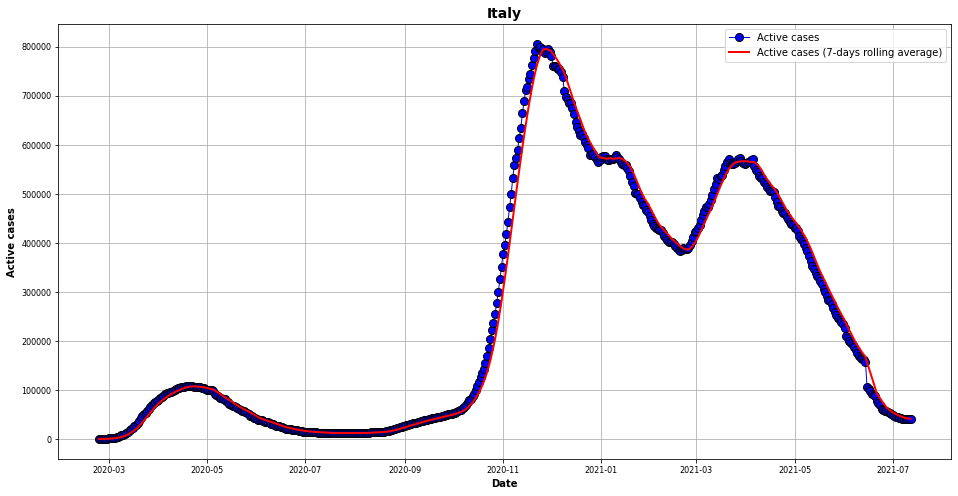

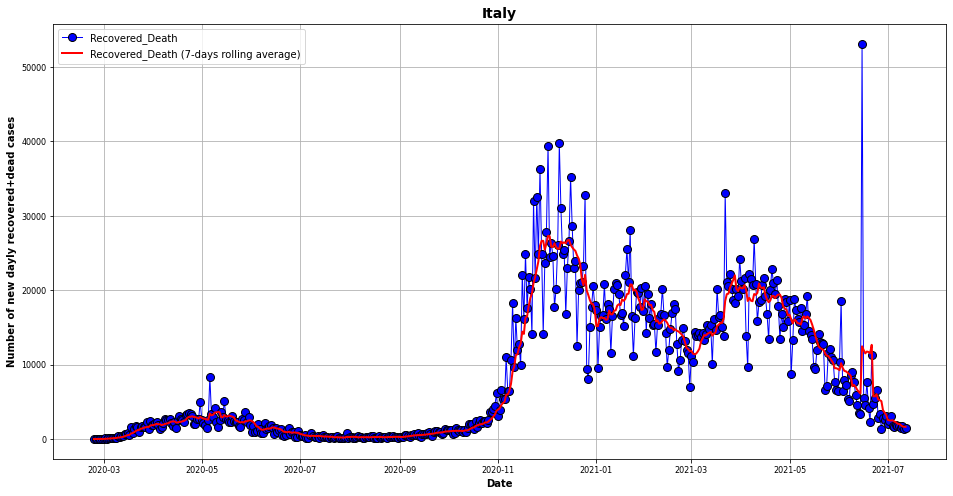

In [5]:
# save figure with plot from january
plt.plot(pd.to_datetime(df.Day), df.Active_cases, 'bo-', lw=1, mfc='b', mec='k', label='Active cases')
plt.plot(pd.to_datetime(df.Day), df.Active_cases_smooth, 'r', lw=2, label='Active cases (7-days rolling average)')
plt.xlabel('Date')
plt.ylabel('Active cases')
plt.title('Italy', weight='bold', fontsize=14)
plt.legend()
plt.grid()
#plt.savefig("active_cases_data_Spain.png", quality=100, transparent=True, dpi=400)
plt.show()

plt.plot(pd.to_datetime(df.Day), df.Recovered_Death, 'bo-', lw=1, mfc='b', mec='k', label='Recovered_Death')
plt.plot(pd.to_datetime(df.Day), df.Recovered_Death_smooth, 'r', lw=2, label='Recovered_Death (7-days rolling average)')
ymin, ymax = plt.ylim()
plt.xlabel('Date')
plt.ylabel('Number of new dayly recovered+dead cases')
plt.title('Italy', weight='bold', fontsize=14)
plt.legend()
plt.grid()
#plt.savefig("recovered_death_data_Spain.png", quality=100, transparent=True, dpi=400)
plt.show()

## Fit ending before peak data
fit from 2020-02-27 to 2020-03-29 with confinement measure aplied on 2020-03-11

In [3]:
filehandler = open('../Advanced-statistics/Results/ita/first_wave/results_before_peak_ita.pkl', 'rb')
res_1 = pickle.load(filehandler)

In [8]:
df[df.Active_cases_smooth == df[df.Day > '2020.10.10'].Active_cases_smooth.max()]

,Day,Confirmed,Recovered,Death,Active_cases,Active_cases_smooth,Recovered_Death,Recovered_Death_smooth
277,2020.11.27,1538217,696647,53677,787893,795480.428571,36294.0,25961.857143


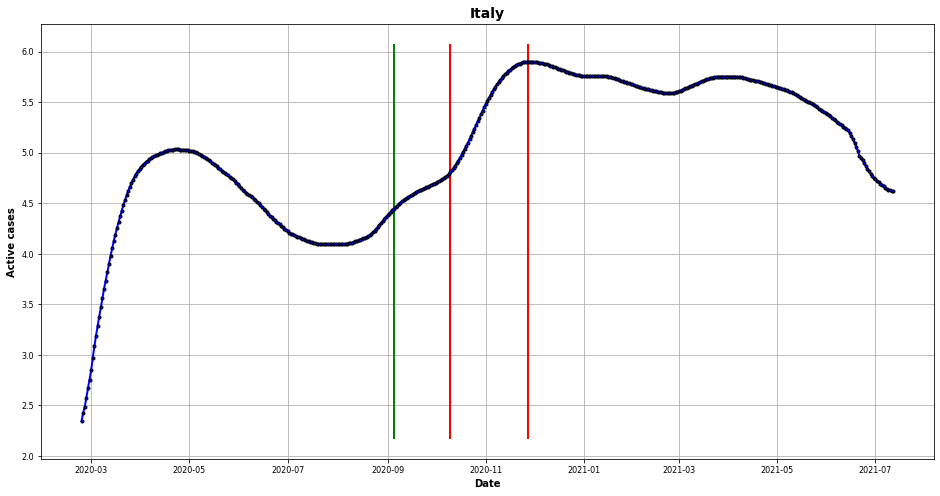

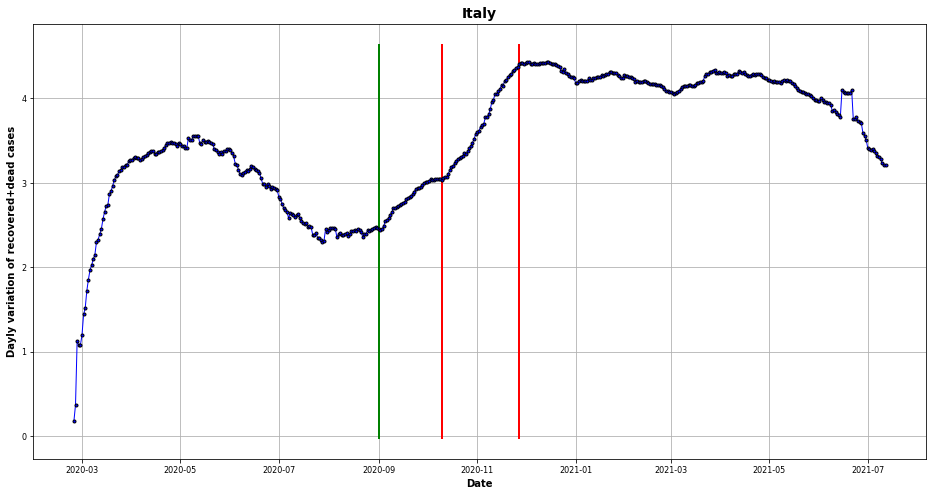

In [22]:
def doubling_time(N0, tau_d, t):
    return N0 + t / tau_d * np.log(2)


plt.plot(pd.to_datetime(df.Day), np.log(df.Active_cases_smooth) / np.log(10), 'bo-', lw=2, markersize=3, mfc='b', mec='k', label='Active cases')
#plt.plot(pd.to_datetime(df.Day)[:15], doubling_time(res_1['I0'], 1./0.24, np.arange(15)))
ymin, ymax = plt.ylim()
plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.09.05']), ymin, ymax, color='g')
plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.10.10']), ymin, ymax, color='r')
plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.11.27']), ymin, ymax, color='r')
plt.xlabel('Date')
plt.ylabel('Active cases')
plt.title('Italy', weight='bold', fontsize=14)
plt.grid()
#plt.xlim(pd.to_datetime(df.Day[df.Day == '2020.09.01']), pd.to_datetime(df.Day[df.Day == '2020.11.20']))
#plt.savefig("active_cases_data_Spain.png", quality=100, transparent=True, dpi=400)
#plt.xlim(pd.to_datetime(df.Day)[0], pd.to_datetime(df.Day)[50])
plt.show()


plt.plot(pd.to_datetime(df.Day), np.log(df.Recovered_Death_smooth) / np.log(10), 'bo-', lw=1, markersize=3, mfc='b', mec='k', label='Recovered_Death new dayly cases')
ymin, ymax = plt.ylim()
plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.09.01']), ymin, ymax, color='g')
plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.10.10']), ymin, ymax, color='r')
plt.vlines(pd.to_datetime(df.Day[df.Day == '2020.11.27']), ymin, ymax, color='r')
plt.xlabel('Date')
plt.ylabel('Dayly variation of recovered+dead cases')
plt.title('Italy', weight='bold', fontsize=14)
plt.grid()
#plt.xlim(pd.to_datetime(df.Day)[0], pd.to_datetime(df.Day)[10])
#plt.savefig("recovered_death_data_Spain.png", quality=100, transparent=True, dpi=400)
plt.show()

In [6]:
f, t = np.unique((res_1['rmu'] * (res_1['p'] + res_1['q'])) > (res_1['beta'] * res_1['p']), return_counts=True)[1]
t / (t + f)

0.531296

In [8]:
def summary(res):
    def median_sd(x):
        median = np.percentile(x, 50)
        sd = np.sqrt(np.mean((x - median) ** 2))
        return sd

    func_dict = {
        "median": lambda x: np.percentile(x, 50),
        "median_std": median_sd,
        "2.5%_hdi": lambda x: np.percentile(x, 2.5),
        "97.5%_hdi": lambda x: np.percentile(x, 97.5),
    }

    subset = {key: value for key, value in res.items() if key in ['beta', 'rmu', 'q', 'p', 'tauI', 'tauX']}

    idata = az.from_pyjags(subset)
    param = az.summary(idata, round_to=4, var_names=['beta', 'rmu', 'q', 'p', 'tauI', 'tauX'],
                        stat_funcs=func_dict)
    return param[['median', 'sd', '2.5%_hdi', '97.5%_hdi', 'r_hat']]

In [8]:
param[['median', 'sd', '2.5%_hdi', '97.5%_hdi', 'r_hat']]

,median,sd,2.5%_hdi,97.5%_hdi,r_hat
beta,0.2416,0.0025,0.2368,0.2468,1.0001
rmu,0.0287,0.0019,0.0253,0.0327,1.0001
q,0.0469,0.0026,0.0434,0.0536,1.0003
p,0.0059,0.0063,0.0002,0.0233,1.0003
tauI,319.6641,79.5885,189.3054,499.7330,1.0000
tauX,6.5936,1.5849,3.9820,10.1682,1.0000


In [12]:
def var_and_error(res):
    tauI = res['tauI'].ravel()
    std_I = np.power(tauI, -1/2)
    sd_std_I = np.std(std_I)
    std_I = np.median(std_I)

    tauX = res['tauX'].ravel()
    std_X = np.power(tauX, -1/2)
    sd_std_X = np.std(std_X)
    std_X = np.median(std_X)

    print('std_I, sd_std_I, std_X, sd_std_X')
    return std_I, sd_std_I, std_X, sd_std_X


var_and_error(res_1)

NameError: name 'res_1' is not defined

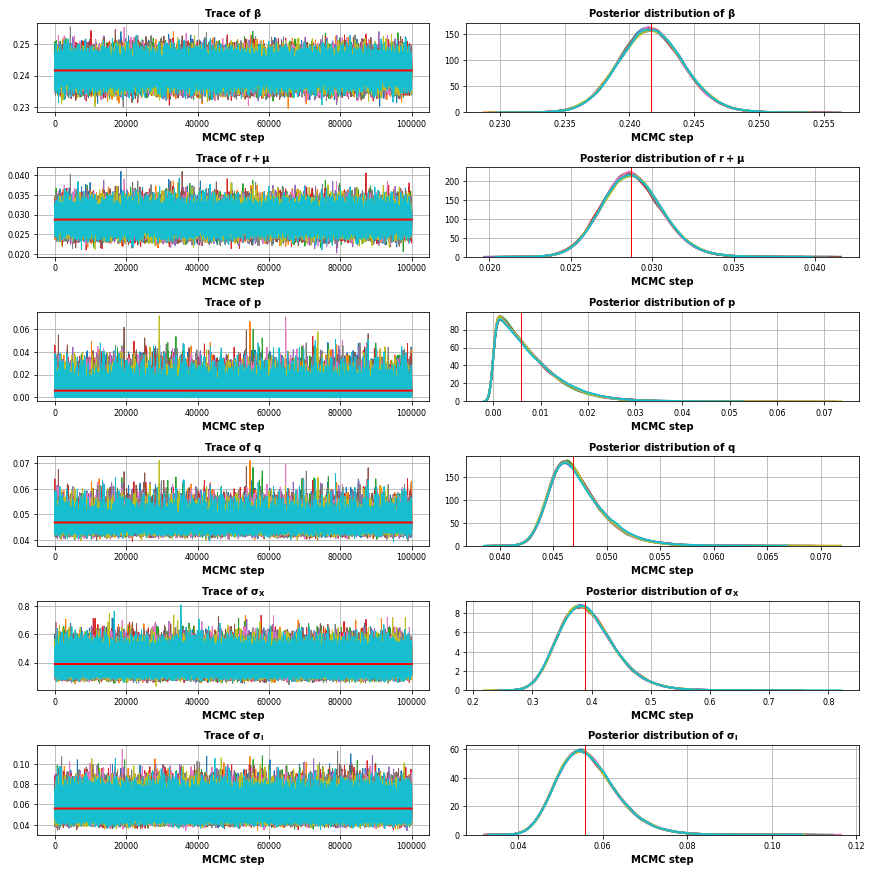

In [7]:
plot_summary(res_1)
plt.savefig("../Advanced-statistics/Results/ita/first_wave/plot/plot_summary_before_peak_ita.png", quality=100, transparent=True, dpi=400)

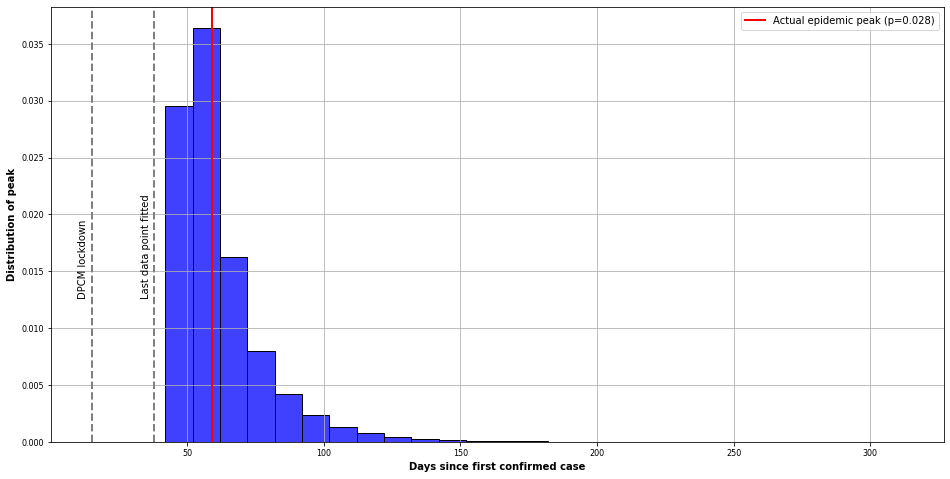

In [9]:
peak_posterior(res_1, offset=5)
plt.grid()
plt.savefig("../Advanced-statistics/Results/ita/first_wave/plot/peak_posterior.png", quality=100, transparent=True, dpi=400)

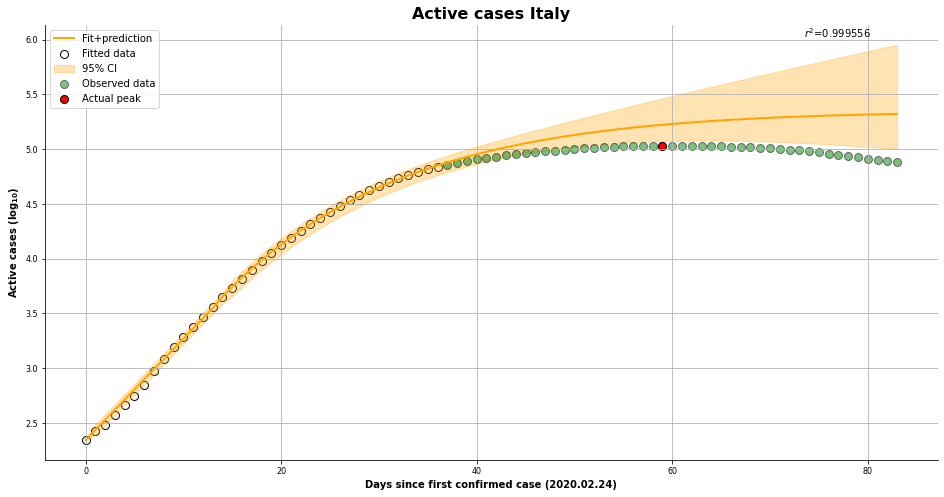

In [14]:
plot_results(res_1, ci=95, Y=True, Z=False, observed=True)
plt.savefig("../Advanced-statistics/Results/ita/first_wave/plot/active_cases_before.png", quality=100, transparent=True, dpi=400)

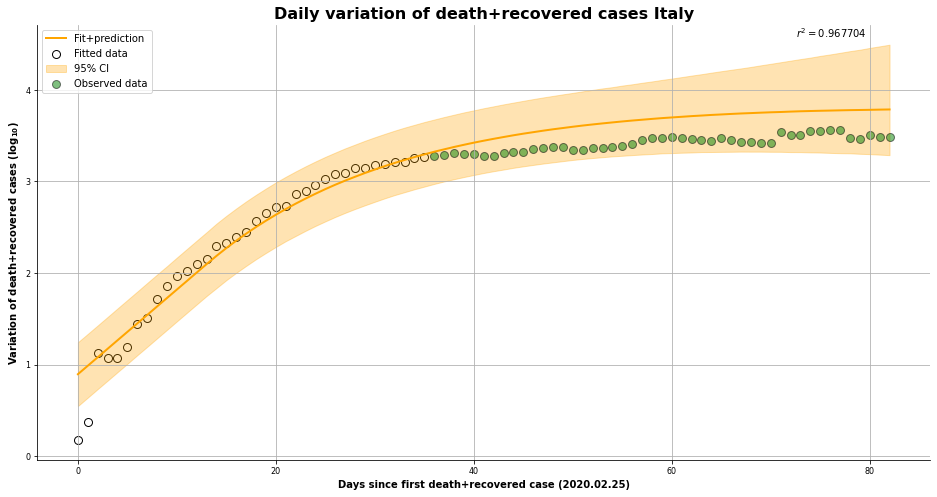

In [15]:
plot_results(res_1, ci=95, Y=False, Z=True, observed=True)
plt.savefig("../Advanced-statistics/Results/ita/first_wave/plot/death_recovered_before.png", quality=100, transparent=True, dpi=400)

## Fit ending after peak data for the daily number of active cases

In [3]:
filehandler = open('../Advanced-statistics/Results/ita/first_wave/results_after_peak_ita.pkl', 'rb')
res_2 = pickle.load(filehandler)

In [32]:
len(df.Day[:len(states[2][::100])]), len(states[2][::100])


(83, 83)

(-10.0, 200.0)

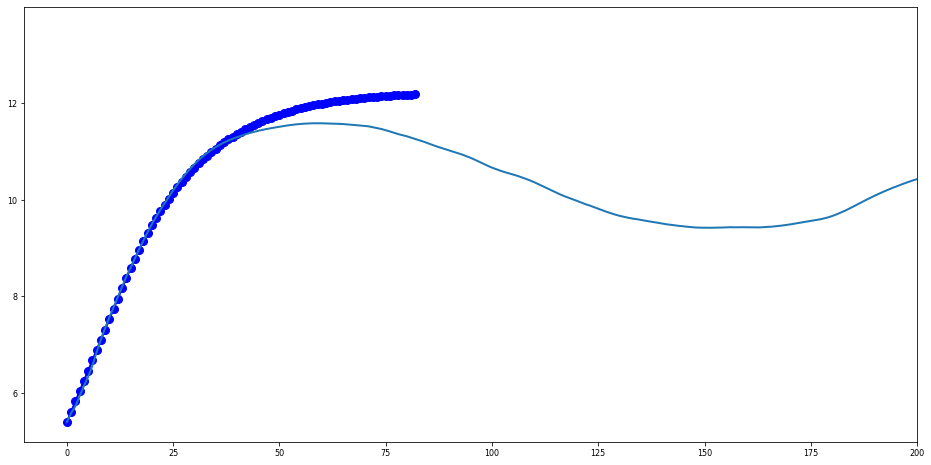

In [30]:
t, *states = solve_SCIR(res_1)


plt.plot(t[::100], np.log(states[2][::100]), 'bo-')
plt.plot(res_1['I'])
plt.xlim(-10, 200)

0.19804205158855578
2020.10.13


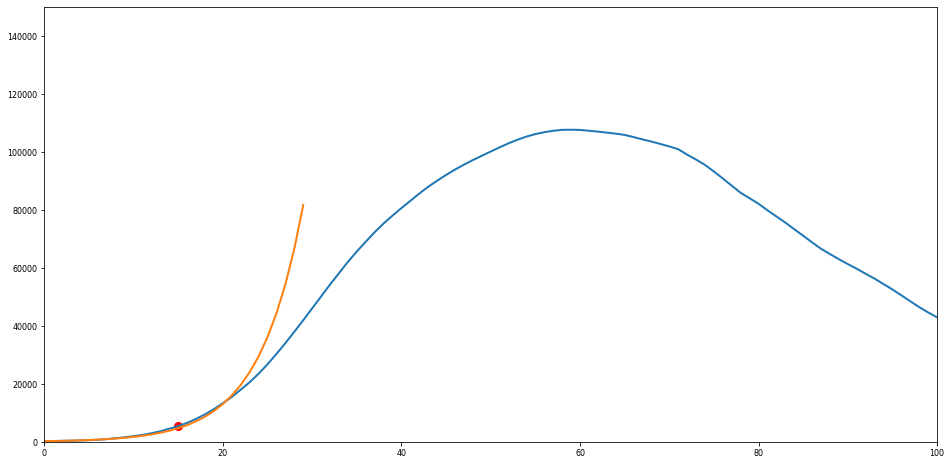

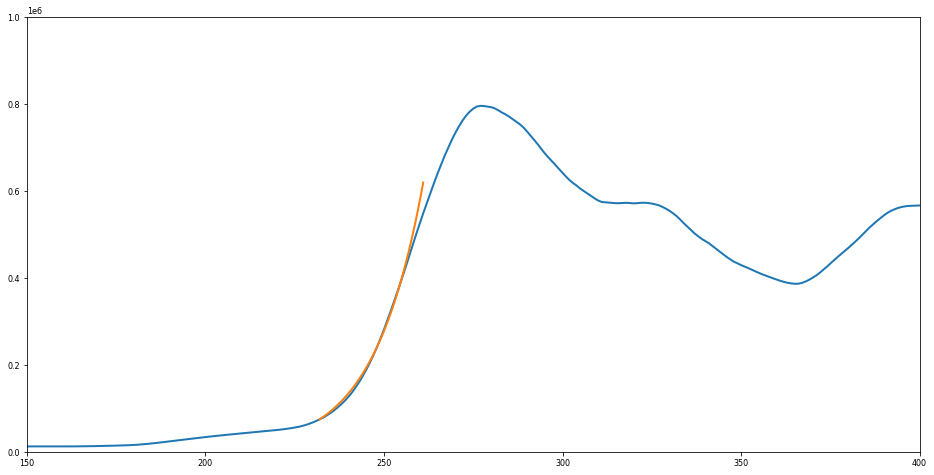

In [73]:
def doubling_time(N0, tau_d, t):
    return N0 *  np.exp(t / tau_d * np.log(2.))

print(np.log(2.) / 3.5)
print(res_2['date'][232])

plt.plot(np.exp(res_2['I']))
plt.plot(np.arange(30), doubling_time(np.exp(res_2['I0']), 3.4, np.arange(30)))
plt.scatter(res_2['tq'], np.exp(res_2['I'][res_2['tq']]), c='r')
plt.xlim(0, 100)
plt.ylim(0, 1.5e5)
plt.show()


popt, pcov = curve_fit(fit_time, x, y)l
plt.plot(np.exp(res_2['I']))
plt.plot(232 + np.arange(30), doubling_time(np.exp(res_2['I'][232]), 9.5, np.arange(30)))
plt.xlim(150, 400)
plt.ylim(0, 1e6)
plt.show()

In [23]:
subset2 = {key: value for key, value in res_2.items() if key in ['beta', 'rmu', 'q', 'p', 'tauI', 'tauX']}

idata2 = az.from_pyjags(subset2)
param2 = az.summary(idata2, round_to=4, var_names=['beta', 'rmu', 'q', 'p', 'tauI', 'tauX'],
                    stat_funcs=func_dict)

In [24]:
param2[['median', 'sd', '2.5%_hdi', '97.5%_hdi', 'r_hat']]

,median,sd,2.5%_hdi,97.5%_hdi,r_hat
beta,0.2434,0.0018,0.2399,0.2469,1.0001
rmu,0.0274,0.0012,0.0252,0.0299,1.0001
q,0.0493,0.0008,0.0478,0.0508,1.0001
p,0.0002,0.0003,0.0000,0.0012,1.0000
tauI,344.3417,66.9322,230.1135,491.4970,1.0000
tauX,9.4860,1.7963,6.4013,13.4187,1.0000


In [29]:
tauI = res_2['tauI'].ravel()
std_I = np.power(tauI, -1/2)
sd_std_I = np.std(std_I)
std_I = np.median(std_I)

tauX = res_2['tauX'].ravel()
std_X = np.power(tauX, -1/2)
sd_std_X = np.std(std_X)
std_X = np.median(std_X)

std_I, sd_std_I, std_X, sd_std_X

(0.05388963184241346,
 0.005319141641614551,
 0.32468226484576057,
 0.031246904914438715)

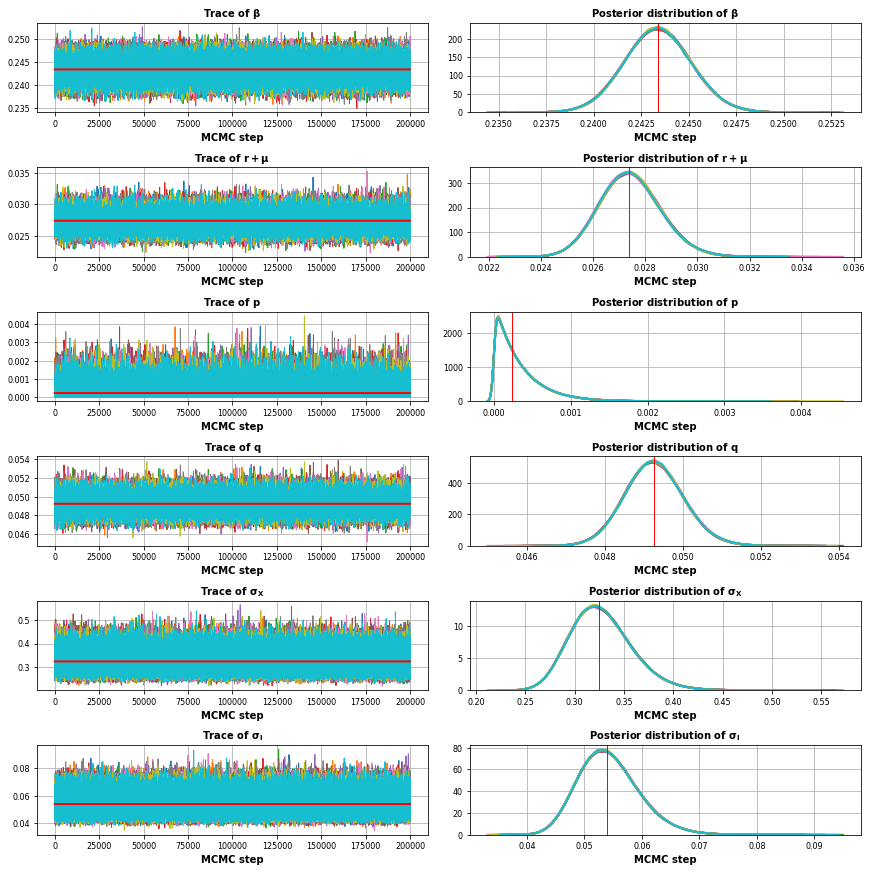

In [25]:
plot_summary(res_2)
plt.savefig("../Advanced-statistics/Results/ita/first_wave/plot/plot_summary_after_peak_ita.png", quality=100, transparent=True, dpi=400)

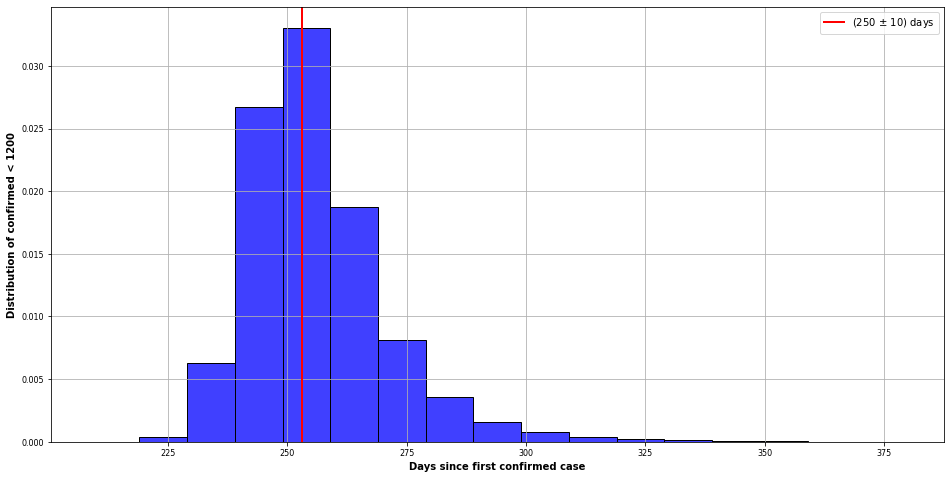

In [4]:
end_epidemic_plot(res_2, '2021.03.01')
plt.savefig("../Advanced-statistics/Results/ita/first_wave/plot/end_epidemic_posterior.png", quality=100, transparent=True, dpi=400)

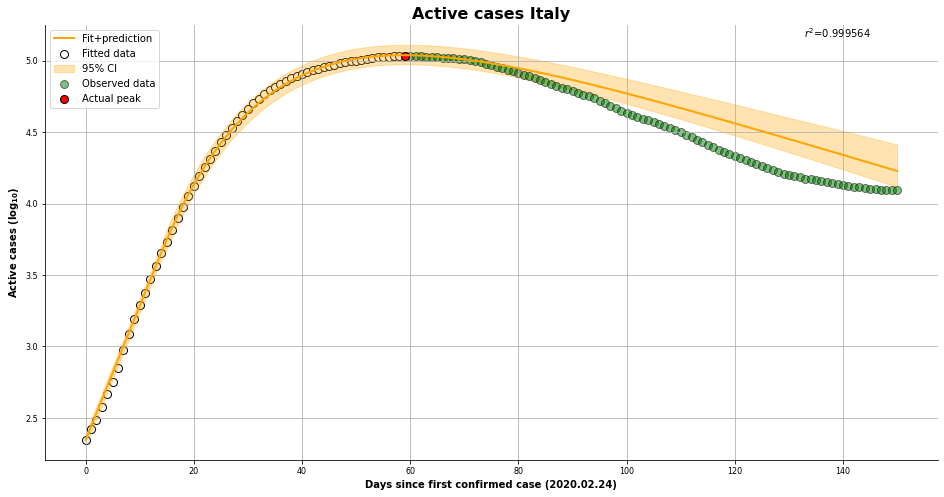

In [5]:
plot_results(res_2, ci=95, Y=True, Z=False, observed=True)
plt.savefig("../Advanced-statistics/Results/ita/first_wave/plot/active_cases_after.png", quality=100, transparent=True, dpi=400)

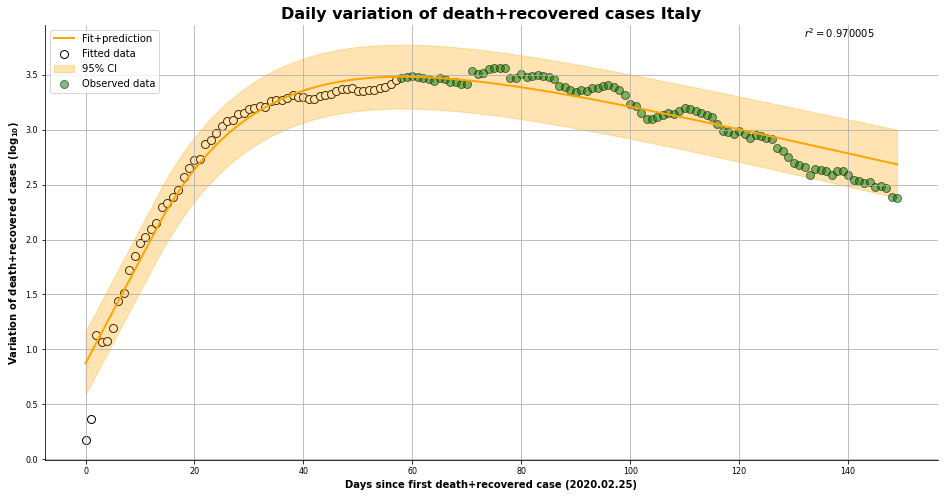

In [6]:
plot_results(res_2, ci=95, Y=False, Z=True, observed=True)
plt.savefig("../Advanced-statistics/Results/ita/first_wave/plot/death_recovered_after.png", quality=100, transparent=True, dpi=400)

In [25]:
filehandler = open('../Advanced-statistics/Results/ita/second_wave/results_before_peak_ita.pkl', 'rb')
res_3 = pickle.load(filehandler)

In [27]:
subset = {key: value for key, value in res_3.items() if key in ['beta', 'rmu', 'q', 'p', 'tauI', 'tauX']}

def median_sd(x):
    median = np.percentile(x, 50)
    sd = np.sqrt(np.mean((x - median) ** 2))
    return sd

func_dict = {
    "median": lambda x: np.percentile(x, 50),
    "median_std": median_sd,
    "2.5%_hdi": lambda x: np.percentile(x, 2.5),
    "97.5%_hdi": lambda x: np.percentile(x, 97.5),
}

idata = az.from_pyjags(subset)
param = az.summary(idata, round_to=4, var_names=['beta', 'rmu', 'q', 'p', 'tauI', 'tauX'],
                    stat_funcs=func_dict)

param[['median', 'sd', '2.5%_hdi', '97.5%_hdi', 'r_hat']]

,median,sd,2.5%_hdi,97.5%_hdi,r_hat
beta,0.0633,0.0028,0.0578,0.0688,1.0
rmu,0.0159,0.0003,0.0153,0.0165,1.0
q,0.0232,0.0431,0.0007,0.1561,1.0
p,3.5239,1.1889,0.7548,4.9365,1.0
tauI,5.2127,0.9310,3.6047,7.2432,1.0
tauX,37.4895,6.5430,26.1404,51.6992,1.0


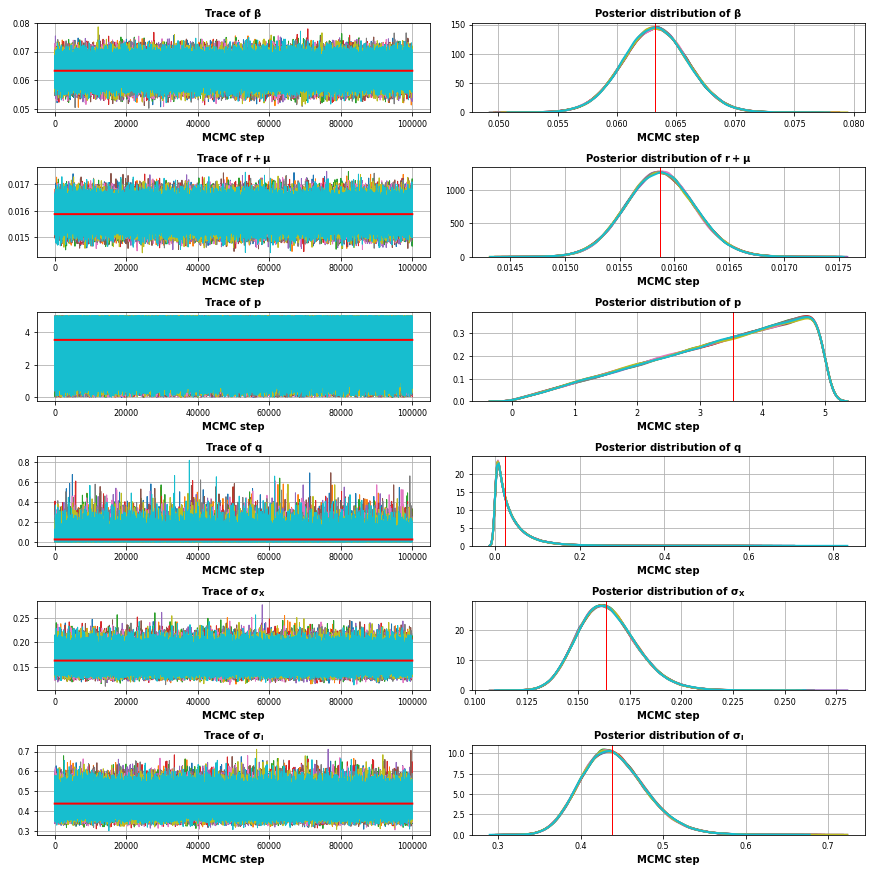

In [26]:
plot_summary(res_3)

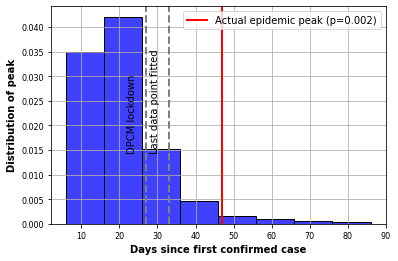

In [99]:
peak_posterior(res_3, offset=5)
plt.grid()

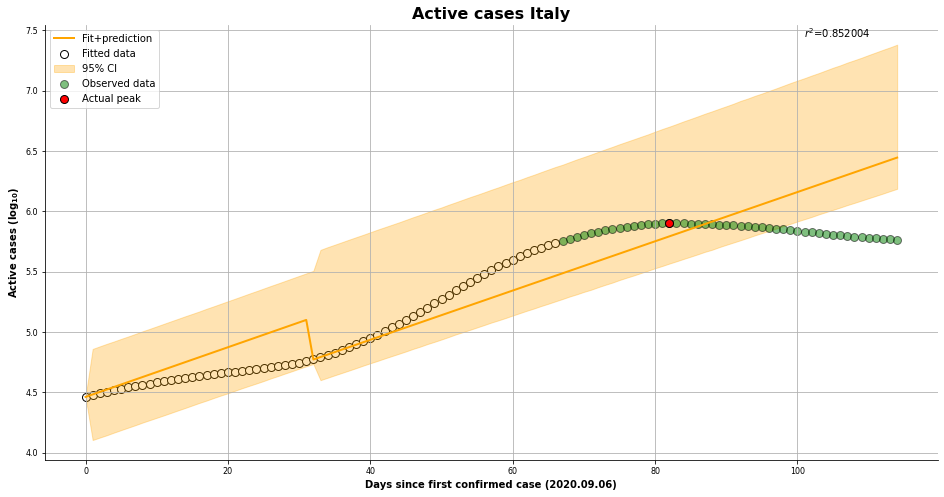

In [28]:
plot_results(res_3, ci=95, Y=True, Z=False, observed=True)

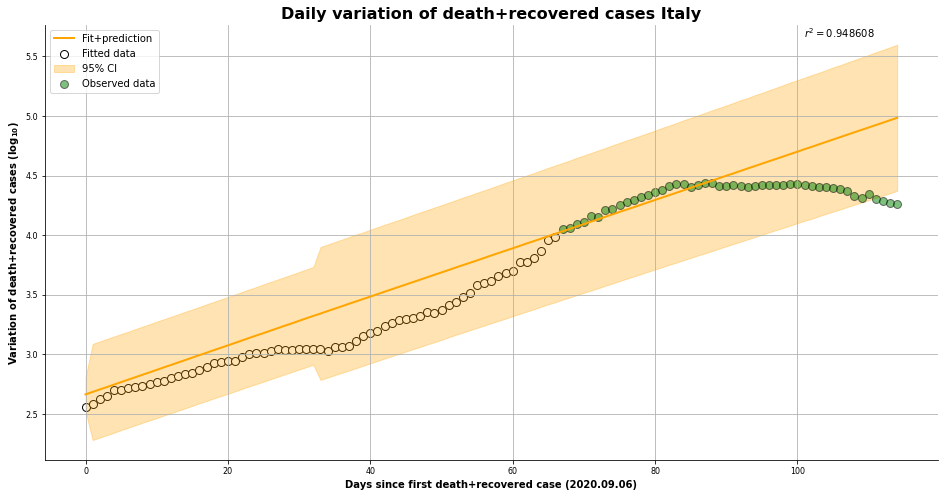

In [29]:
plot_results(res_3, ci=95, Y=False, Z=True, observed=True)

In [30]:
f, t = np.unique((res_3['rmu'] * (res_3['p'] + res_3['q'])) > (res_3['beta'] * res_3['p']), return_counts=True)[1]
t / (t + f) * 100

ValueError: not enough values to unpack (expected 2, got 1)

In [89]:
filehandler = open('../Advanced-statistics/Results/ita/second_wave/results_after_peak_ita.pkl', 'rb')
res_4 = pickle.load(filehandler)

In [105]:
subset = {key: value for key, value in res_4.items() if key in ['beta', 'rmu', 'q', 'p', 'tauI', 'tauX']}

idata = az.from_pyjags(subset)
param = az.summary(idata, round_to=4, var_names=['beta', 'rmu', 'q', 'p', 'tauI', 'tauX'],
                    stat_funcs=func_dict)


param[['median', 'sd', '2.5%_hdi', '97.5%_hdi', 'r_hat']]


,median,sd,2.5%_hdi,97.5%_hdi,r_hat
beta,0.0869,0.0009,0.0852,0.0887,1.0001
rmu,0.0172,0.0007,0.0159,0.0187,1.0001
q,0.0857,0.0165,0.0668,0.1287,1.0003
p,0.0405,0.0305,0.0037,0.1187,1.0003
tauI,512.9681,111.6962,325.3175,761.2834,1.0000
tauX,12.8516,2.6858,8.3033,18.8014,1.0000


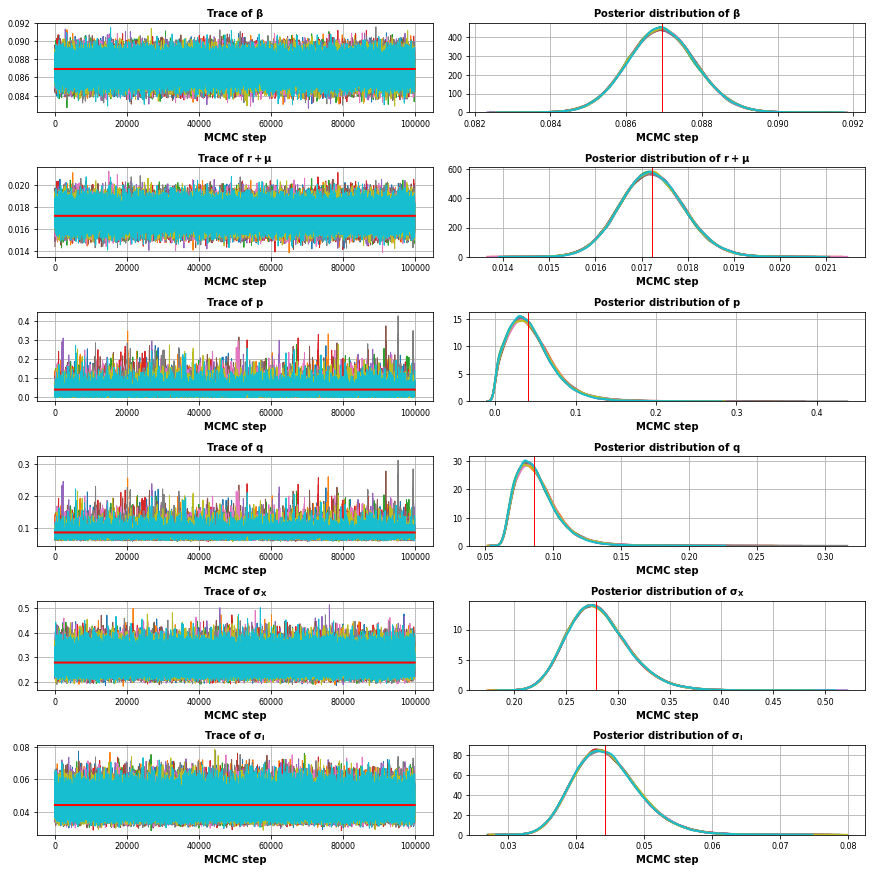

In [91]:
plot_summary(res_4)

In [93]:
end_epidemic_plot(res_4, '2021.11.14')

ValueError: cannot convert float NaN to integer

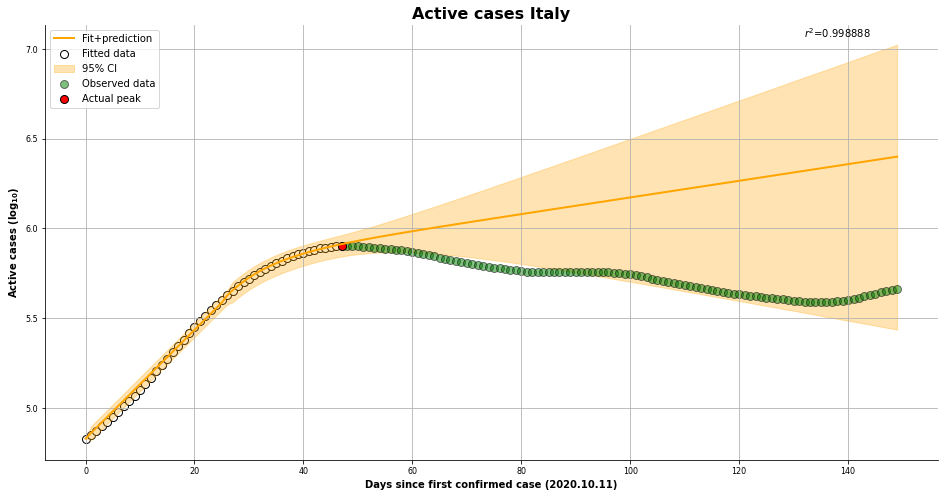

In [94]:
plot_results(res_4, ci=95, Y=True, Z=False, observed=True)

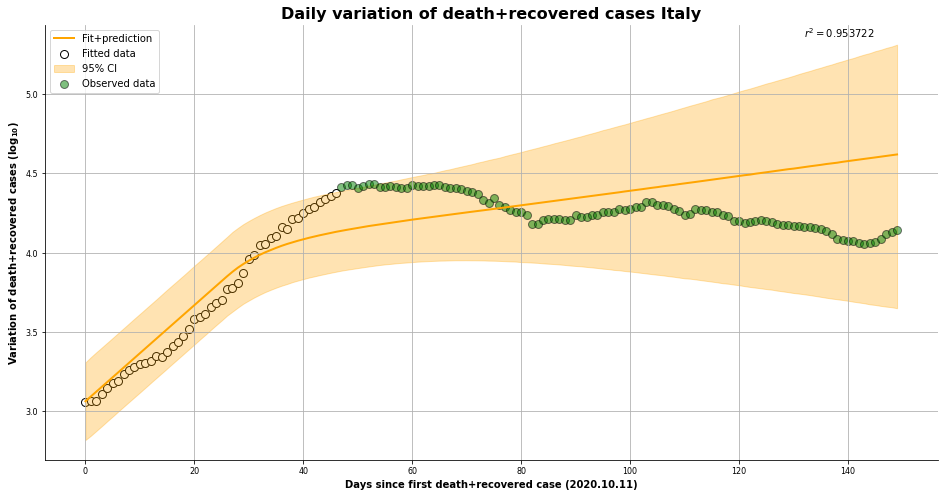

In [95]:
plot_results(res_4, ci=95, Y=False, Z=True, observed=True)

In [62]:
filehandler = open('../Advanced-statistics/Results/fra/first_wave/results_before_peak_fra.pkl', 'rb')
res_5 = pickle.load(filehandler)

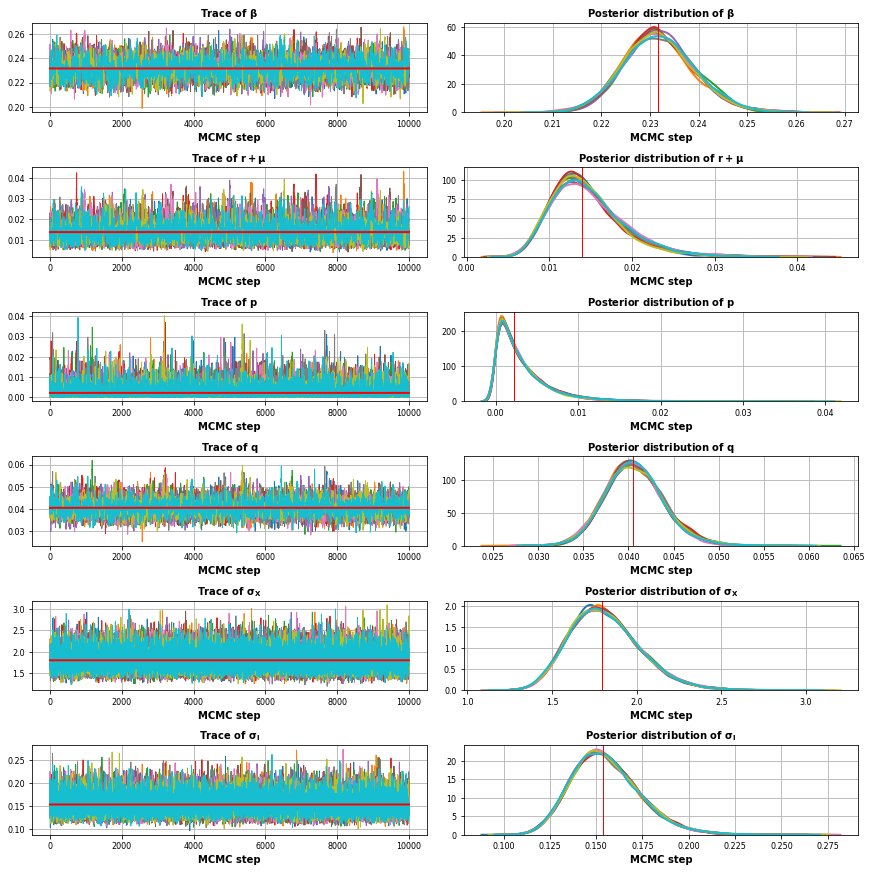

In [54]:
plot_summary(res_5)
#plt.savefig("../Advanced-statistics/Results/ita/first_wave/plot/plot_summary_before_peak_ita.png", quality=100, transparent=True, dpi=400)

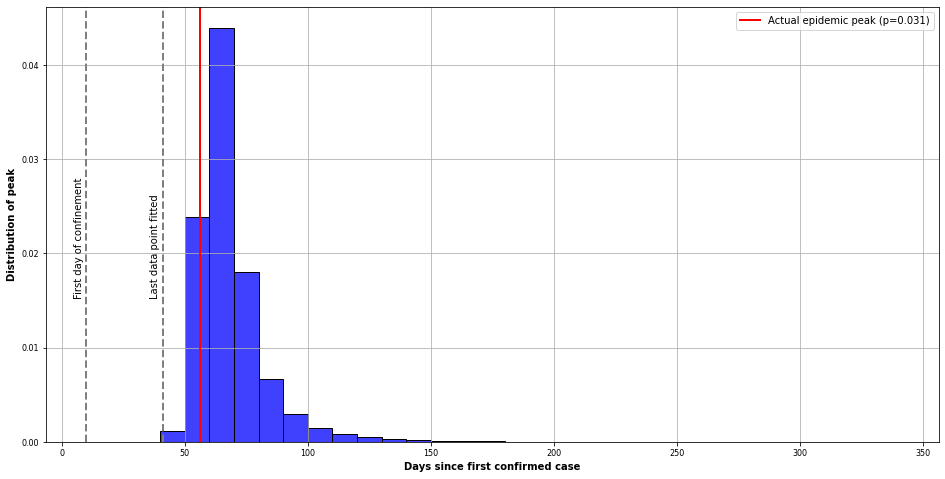

In [57]:
peak_posterior(res_5, offset=5)
plt.grid()
#plt.savefig("../Advanced-statistics/Results/fra/first_wave/plot/peak_posterior.png", quality=100, transparent=True, dpi=400)

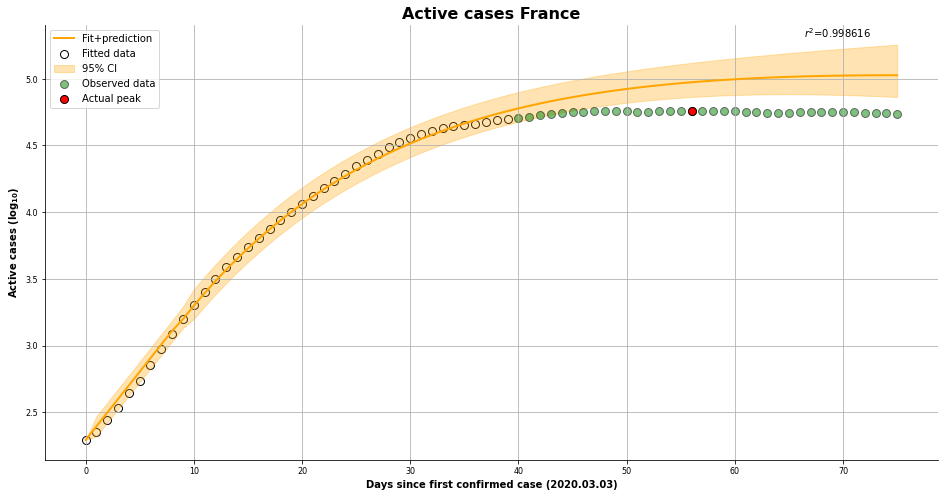

In [58]:
plot_results(res_5, ci=95, Y=True, Z=False, observed=True)
#plt.savefig("../Advanced-statistics/Results/fra/first_wave/plot/active_cases_after.png", quality=100, transparent=True, dpi=400)

In [63]:
filehandler = open('../Advanced-statistics/Results/fra/first_wave/results_after_peak_fra.pkl', 'rb')
res_6 = pickle.load(filehandler)

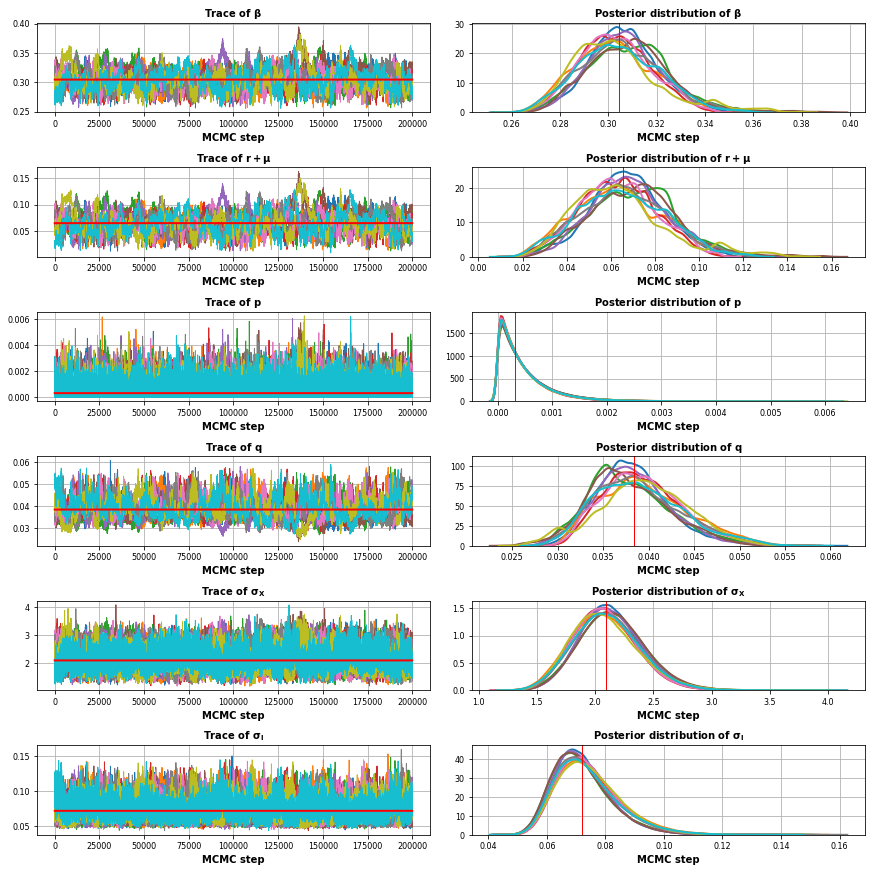

In [64]:
plot_summary(res_6)
#plt.savefig("../Advanced-statistics/Results/ita/first_wave/plot/plot_summary_after_peak_ita.png", quality=100, transparent=True, dpi=400)

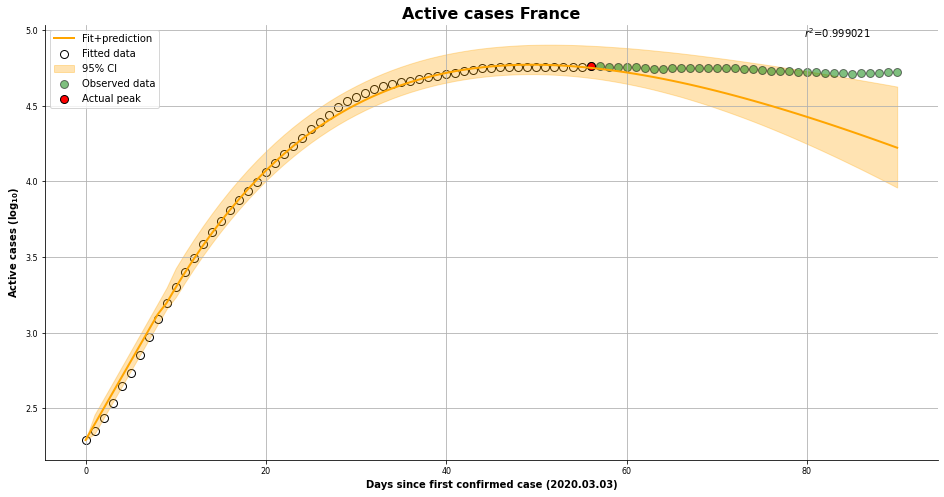

In [65]:
plot_results(res_6, ci=95, Y=True, Z=False, observed=True)
#plt.xlim(0, 90)
#plt.savefig("../Advanced-statistics/Results/fra/first_wave/plot/active_cases_after.png", quality=100, transparent=True, dpi=400)

In [3]:
filehandler = open('../Advanced-statistics/Results/esp/results_before_peak_esp.pkl', 'rb')
res_8 = pickle.load(filehandler)

In [13]:
print(var_and_error(res_8))

summary(res_8)

std_I, sd_std_I, std_X, sd_std_X
(0.13234200884743744, 0.01955454105820908, 1.1424682102759292, 0.1784270888174264)


,median,sd,2.5%_hdi,97.5%_hdi,r_hat
beta,0.3697,0.0081,0.3552,0.3870,1.0015
rmu,0.0204,0.0052,0.0128,0.0330,1.0016
q,0.0551,0.0049,0.0479,0.0668,1.0027
p,0.0070,0.0095,0.0003,0.0346,1.0020
tauI,57.0959,16.2716,31.1425,94.9077,1.0002
tauX,0.7661,0.2300,0.4053,1.3026,1.0001


In [4]:
f, t = np.unique((res_8['rmu'] * (res_8['p'] + res_8['q'])) > (res_8['beta'] * res_8['p']), return_counts=True)[1]
t / (t + f)

0.26742

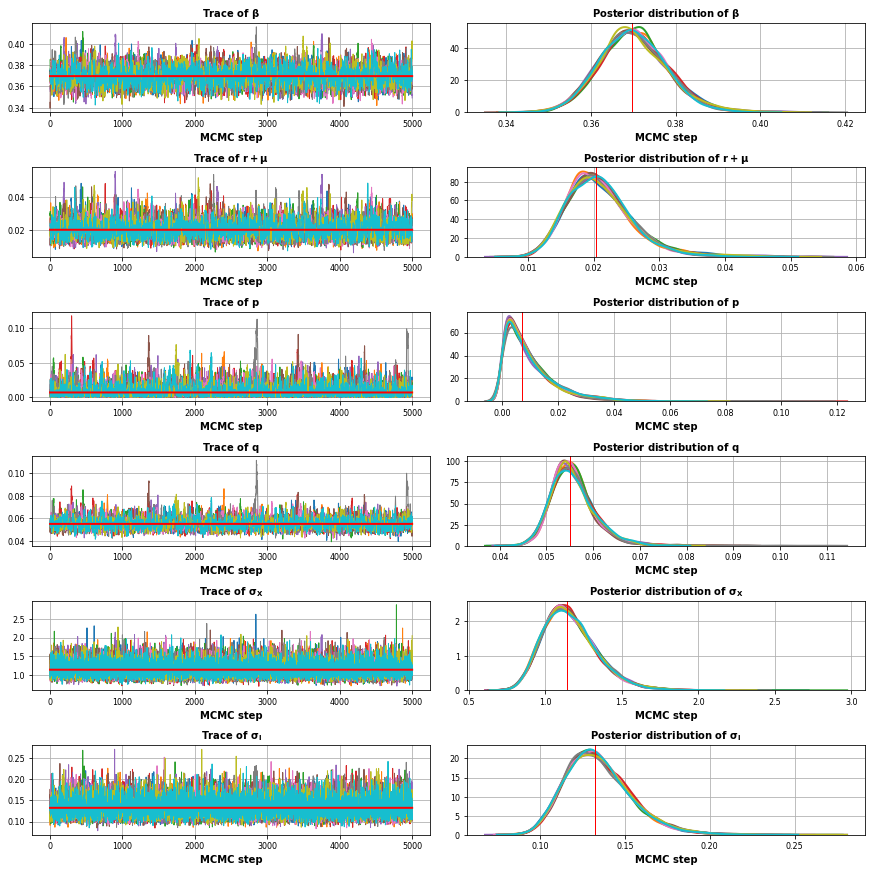

In [5]:
plot_summary(res_8)
plt.savefig("../Advanced-statistics/Results/esp/plot/plot_summary_before_peak_esp.png", quality=100, transparent=True, dpi=400)

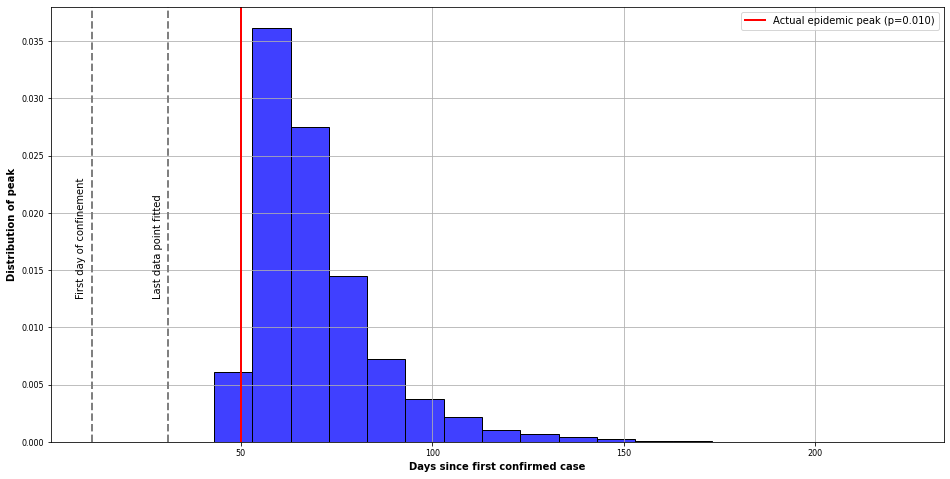

In [7]:
peak_posterior(res_8, offset=4)
plt.grid()
plt.savefig("../Advanced-statistics/Results/esp/plot/peak_posterior.png", quality=100, transparent=True, dpi=400)

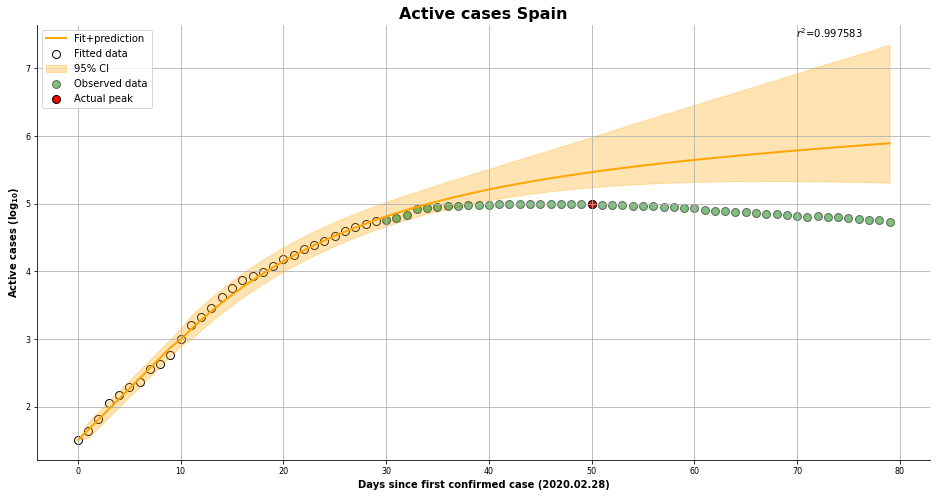

In [14]:
plot_results(res_8, ci=95, Y=True, Z=False, observed=True)
plt.savefig("../Advanced-statistics/Results/esp/plot/active_cases_before.png", quality=100, transparent=True, dpi=400)

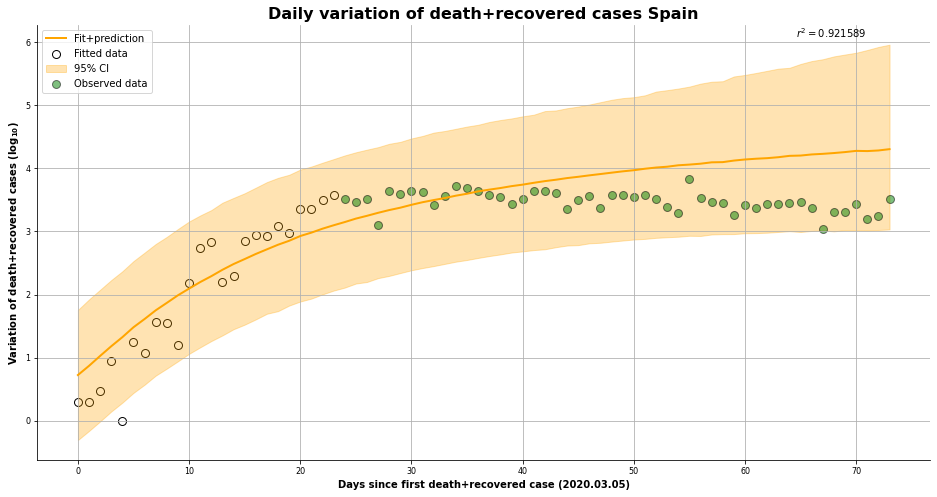

In [15]:
plot_results(res_8, ci=95, Y=False, Z=True, observed=True)
plt.savefig("../Advanced-statistics/Results/esp/plot/death_recovered_before.png", quality=100, transparent=True, dpi=400)

In [16]:
filehandler = open('../Advanced-statistics/Results/esp/results_after_peak_esp.pkl', 'rb')
res_9 = pickle.load(filehandler)

In [17]:
print(var_and_error(res_9))

summary(res_9)

std_I, sd_std_I, std_X, sd_std_X
(0.13914277570703493, 0.020103414726478242, 0.9783779037168354, 0.49702296416434916)


,median,sd,2.5%_hdi,97.5%_hdi,r_hat
beta,0.3987,0.0702,0.3843,0.6683,1.2601
rmu,0.0332,0.0746,0.0241,0.3190,1.2683
q,0.0594,0.0095,0.0265,0.0642,1.2650
p,0.0004,0.0021,0.0000,0.0088,1.2293
tauI,51.6510,19.8607,31.8416,115.3979,1.2281
tauX,1.0447,0.3680,0.1300,1.6247,1.2494


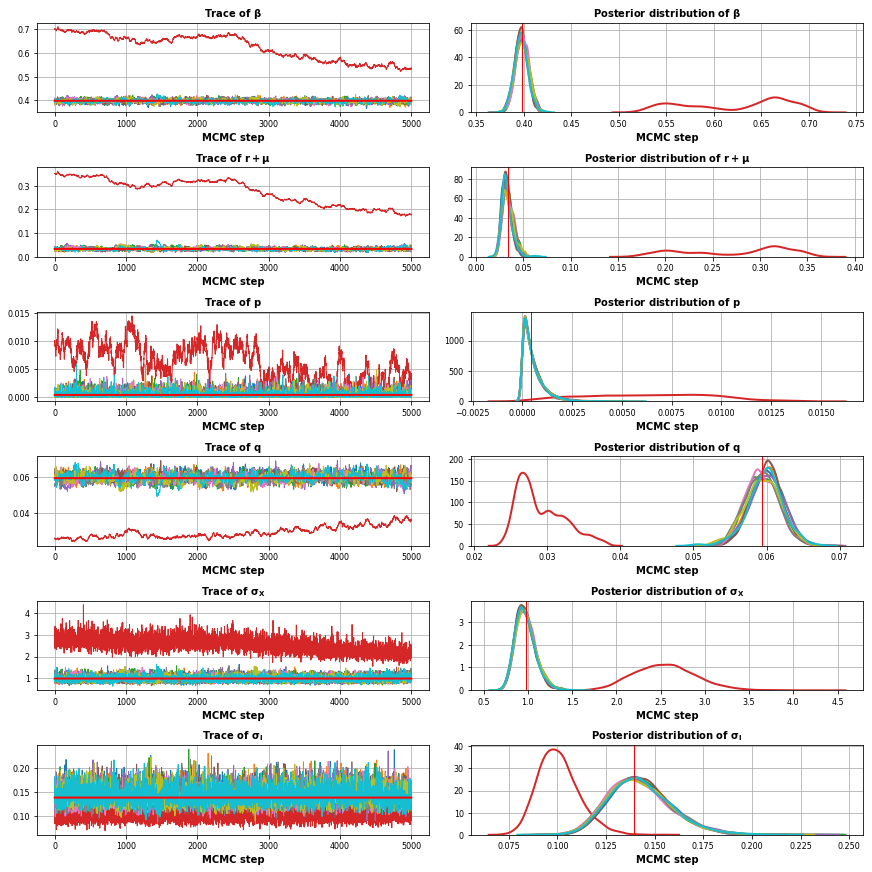

In [18]:
plot_summary(res_9)
plt.savefig("../Advanced-statistics/Results/esp/plot/plot_summary_after_peak_esp.png", quality=100, transparent=True, dpi=400)

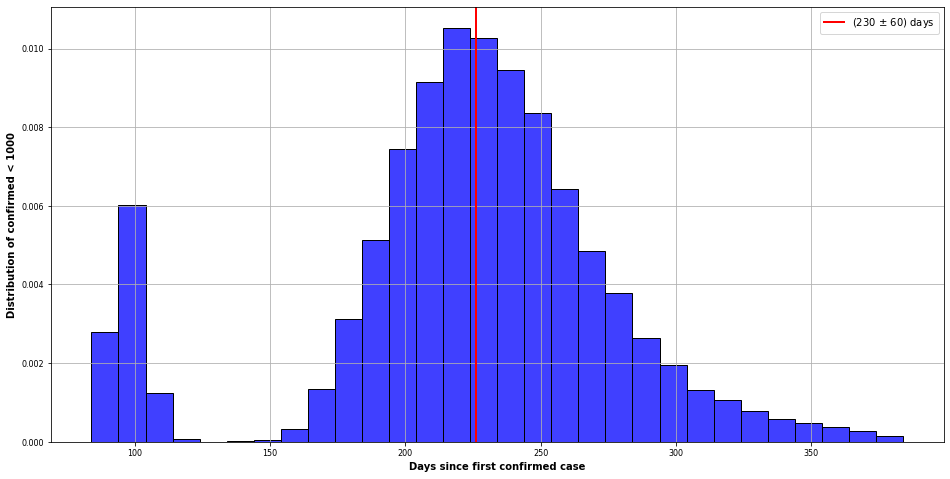

In [19]:
end_epidemic_plot(res_9, '2021.03.14')
plt.savefig("../Advanced-statistics/Results/esp/plot/end_epidemic_posterior.png", quality=100, transparent=True, dpi=400)

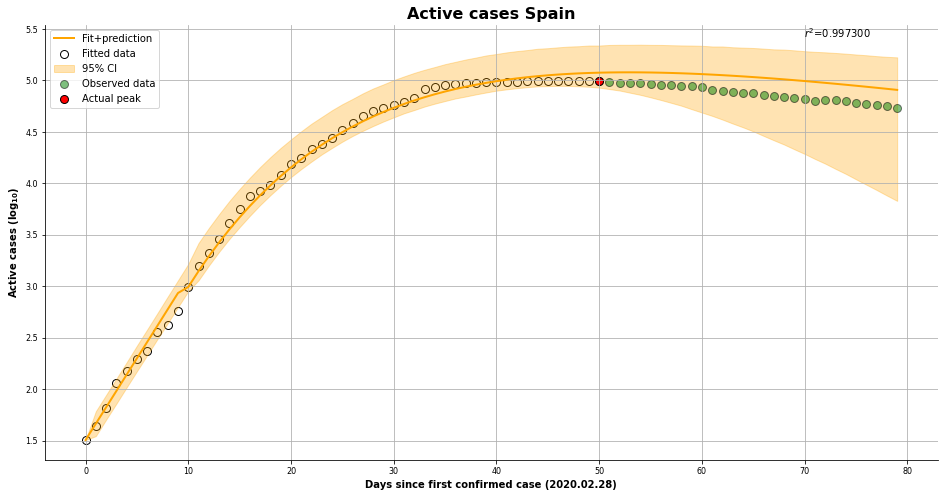

In [20]:
plot_results(res_9, ci=95, Y=True, Z=False, observed=True)
plt.savefig("../Advanced-statistics/Results/esp/plot/active_cases_after.png", quality=100, transparent=True, dpi=400)

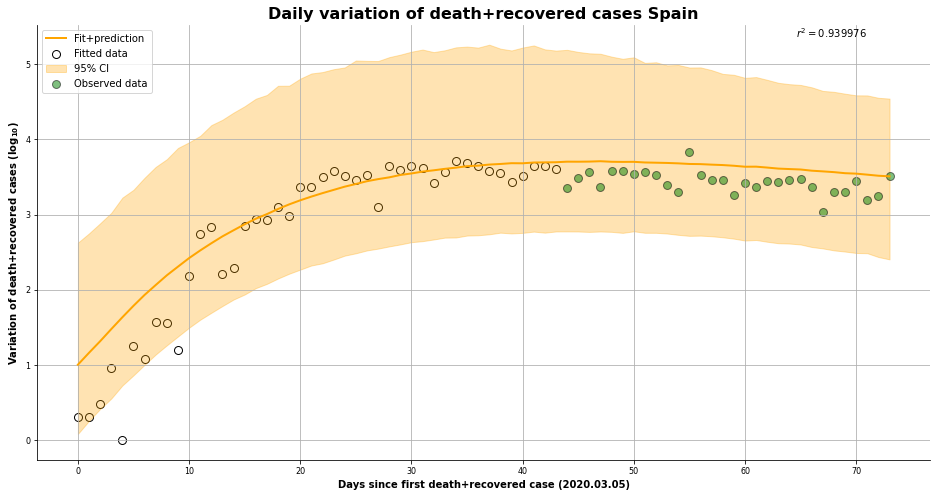

In [21]:
plot_results(res_9, ci=95, Y=False, Z=True, observed=True)
plt.savefig("../Advanced-statistics/Results/esp/plot/death_recovered_after.png", quality=100, transparent=True, dpi=400)